<a href="https://colab.research.google.com/github/medbar/maga_sis/blob/main/2/ED/ED_Mitrofanov_lab1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Пороговый классификатор на примере детектора выстрела
1. Есть Гитхаб куда будут залиты исходники лабы.  
1. <font color='green'>Есть гуглдиск и гуглколаб - реализоавно приложение hello world</font >
1. <font color='green'> Загружена база на гугл диск </font >
1. <font color='green'>Расчитаны фичи с помощью либроза и сохранены в pkl на гуглдиск  </font >
1. <font color='green'> Данные разделены на трэйн и валидацию!!  </font >
1. <font color='green'> реализован ML классификатор  </font >
1.<font color='green'>  Посчитана метрика f1 и конф матрица на трэйне и на врефикации  </font >
1. <font color='green'>  Обновлены f1 по результатам перебора параметров </font >

In [ ]:
#@title It is hello colab form. { run: "auto", display-mode: "form" }
hello="world" #@param ["world", "Student", "Colab", "Teacher"]
print(f"Hello {hello}!")

Hello world!


In [ ]:
from google.colab import drive
import io
import numpy as np
import zipfile
import IPython.display as ipd
from scipy.io import wavfile
import pandas as pd
import librosa.display
import librosa
import pickle
import sklearn
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.pipeline import Pipeline

import matplotlib.pyplot as plt
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!ls /content/gdrive/MyDrive/учебка/магистратура/2/ED/

 audio_train.zip  'ED Mitrofanov lab1'	 mfcc.pickle   train.csv


In [ ]:
data_zipped = zipfile.ZipFile('/content/gdrive/MyDrive/учебка/магистратура/2/ED/audio_train.zip')

In [ ]:
data_labels_df = pd.read_csv('/content/gdrive/MyDrive/учебка/магистратура/2/ED/train.csv')

In [ ]:
# from slides 
def read_from_zip(zip_store, filename):
    with io.BytesIO() as bytes_buff:
        bytes_data = zip_store.read(filename)
        bytes_buff.write(bytes_data)
        bytes_buff.seek(0)
        sr, wave = wavfile.read(bytes_buff)
    return sr, wave

    
def draw_waveform(wav, sr, figsize=(14, 5)):
    # Отрисовка звукового сигнала во временной области
    plt.figure(figsize=figsize)
    librosa.display.waveplot(wav, sr=sr)
    player = ipd.Audio(wav, rate=sr)
    ipd.display(player)

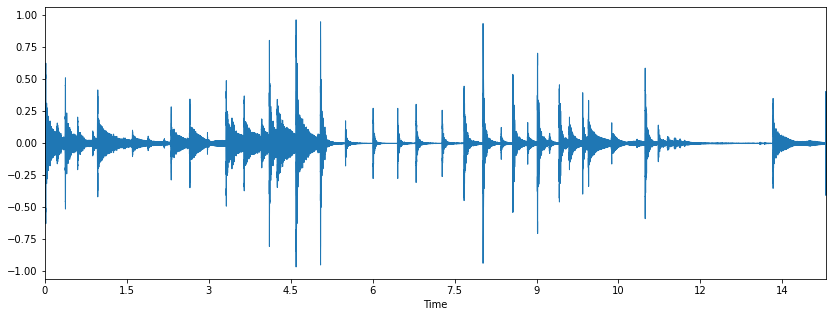

In [ ]:
sr, wave = read_from_zip(data_zipped, "train/1fae738201b76235694f.wav")
draw_waveform(wave, sr)

In [ ]:
feats = []
for id, (fn, l) in data_labels_df.iterrows():
  sr_new, wav = read_from_zip(data_zipped, 'train/'+fn)
  assert sr_new == sr, f"{sr_new} {sr}"
  feats.append(librosa.feature.mfcc(wav, sr=sr_new, n_mfcc=40))

In [ ]:
with open('/content/gdrive/MyDrive/учебка/магистратура/2/ED/mfcc.pickle', 'wb') as f:
   pickle.dump(feats, f)

In [ ]:
with open('/content/gdrive/MyDrive/учебка/магистратура/2/ED/mfcc.pickle', 'rb') as f:
   feats = pickle.load(f)

In [ ]:
data_labels_df['label']

0       Finger_snapping
1                Squeak
2        Electric_piano
3             Harmonica
4            Snare_drum
             ...       
5678              Cello
5679            Shatter
5680              Cello
5681         Snare_drum
5682               Fart
Name: label, Length: 5683, dtype: object

In [ ]:
id2label = [l for l in set(data_labels_df['label'])]
label2id = {l:i for i, l in enumerate(id2label)}
data_labels_ids = np.array([label2id[m] for m in data_labels_df['label']])
train_X, test_X, train_y, test_y = feats[800:], feats[:800], data_labels_ids[800:], data_labels_ids[:800]  #train_test_split(feats, data_labels_ids)



In [ ]:
def get_avg_std(feat: np.array):
  return np.concatenate((np.mean(feat, axis=1), np.std(feat, axis=1)))

train_X_avg_std = np.stack(map(get_avg_std, train_X))
test_X_avg_std = np.stack(map(get_avg_std, test_X))

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2822: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if self.run_code(code, result):


In [ ]:
from sklearn import manifold
import matplotlib.pyplot as plt

def t_SNE_plot(X, y):
  assert isinstance(X, np.ndarray) and isinstance(y, np.ndarray)
  #m2color = {"": 'b', ",":"g", ".": "r"}
  tsne = manifold.TSNE(n_components=2, init='random', random_state=0)
  X_t = tsne.fit_transform(X)
  plt.figure(figsize=(10, 10))
  labels = set(y)
  for m in labels:
    feats = X_t[y==m]
    plt.scatter(feats[:,0], feats[:, 1])
  #plt.legend([m for m in labels])
  plt.show()

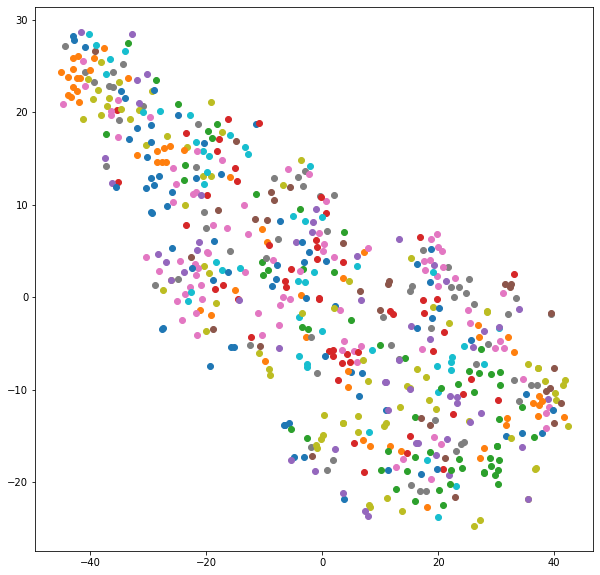

In [ ]:
t_SNE_plot(test_X_avg_std[:600], test_y[:600])

In [ ]:
cls = sklearn.pipeline.Pipeline((('pca', sklearn.decomposition.PCA(n_components=40)), ("cls", LogisticRegression(class_weight='balanced'))))
cls.fit(train_X_avg_std[:1000], train_y[:1000])

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Pipeline(memory=None,
         steps=[('pca',
                 PCA(copy=True, iterated_power='auto', n_components=40,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('cls',
                 LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [ ]:
print(metrics.classification_report(test_y, cls.predict(test_X_avg_std)))

              precision    recall  f1-score   support

           0       0.36      0.32      0.34        31
           1       0.31      0.36      0.33        14
           2       0.00      0.00      0.00         5
           3       0.00      0.00      0.00         9
           4       0.35      0.42      0.39        26
           5       0.18      0.20      0.19        10
           6       0.37      0.42      0.39        26
           7       0.44      0.29      0.35        28
           8       0.70      0.44      0.54        16
           9       0.21      0.21      0.21        24
          10       0.00      0.00      0.00        11
          11       0.35      0.30      0.32        20
          12       0.52      0.52      0.52        21
          13       0.12      0.14      0.13        22
          14       0.04      0.20      0.07         5
          15       0.33      0.20      0.25        10
          16       0.21      0.17      0.19        24
          17       0.15    

In [ ]:
cls = sklearn.neighbors.KNeighborsClassifier(n_neighbors=5, metric='euclidean')
cls = sklearn.pipeline.Pipeline((('norm', sklearn.preprocessing.Normalizer()), ("cls", cls)))
cls.fit(train_X_avg_std, train_y)
print(metrics.classification_report(test_y, cls.predict(test_X_avg_std)))

              precision    recall  f1-score   support

           0       0.73      0.61      0.67        31
           1       0.12      0.14      0.13        14
           2       0.00      0.00      0.00         5
           3       0.50      0.22      0.31         9
           4       0.42      0.58      0.48        26
           5       0.60      0.30      0.40        10
           6       0.29      0.38      0.33        26
           7       0.70      0.50      0.58        28
           8       0.80      0.75      0.77        16
           9       0.73      0.46      0.56        24
          10       0.08      0.27      0.12        11
          11       0.31      0.50      0.38        20
          12       0.50      0.43      0.46        21
          13       0.33      0.36      0.35        22
          14       0.20      0.20      0.20         5
          15       0.75      0.30      0.43        10
          16       0.32      0.50      0.39        24
          17       0.33    

{'Saxophone': 0, 'Meow': 1, 'Microwave_oven': 2, 'Telephone': 3, 'Bass_drum': 4, 'Harmonica': 5, 'Laughter': 6, 'Hi-hat': 7, 'Cowbell': 8, 'Gong': 9, 'Drawer_open_or_close': 10, 'Knock': 11, 'Cello': 12, 'Writing': 13, 'Scissors': 14, 'Chime': 15, 'Tearing': 16, 'Flute': 17, 'Fart': 18, 'Burping_or_eructation': 19, 'Computer_keyboard': 20, 'Applause': 21, 'Double_bass': 22, 'Bark': 23, 'Snare_drum': 24, 'Tambourine': 25, 'Shatter': 26, 'Finger_snapping': 27, 'Clarinet': 28, 'Fireworks': 29, 'Gunshot_or_gunfire': 30, 'Glockenspiel': 31, 'Violin_or_fiddle': 32, 'Keys_jangling': 33, 'Oboe': 34, 'Electric_piano': 35, 'Squeak': 36, 'Acoustic_guitar': 37, 'Trumpet': 38, 'Bus': 39, 'Cough': 40}


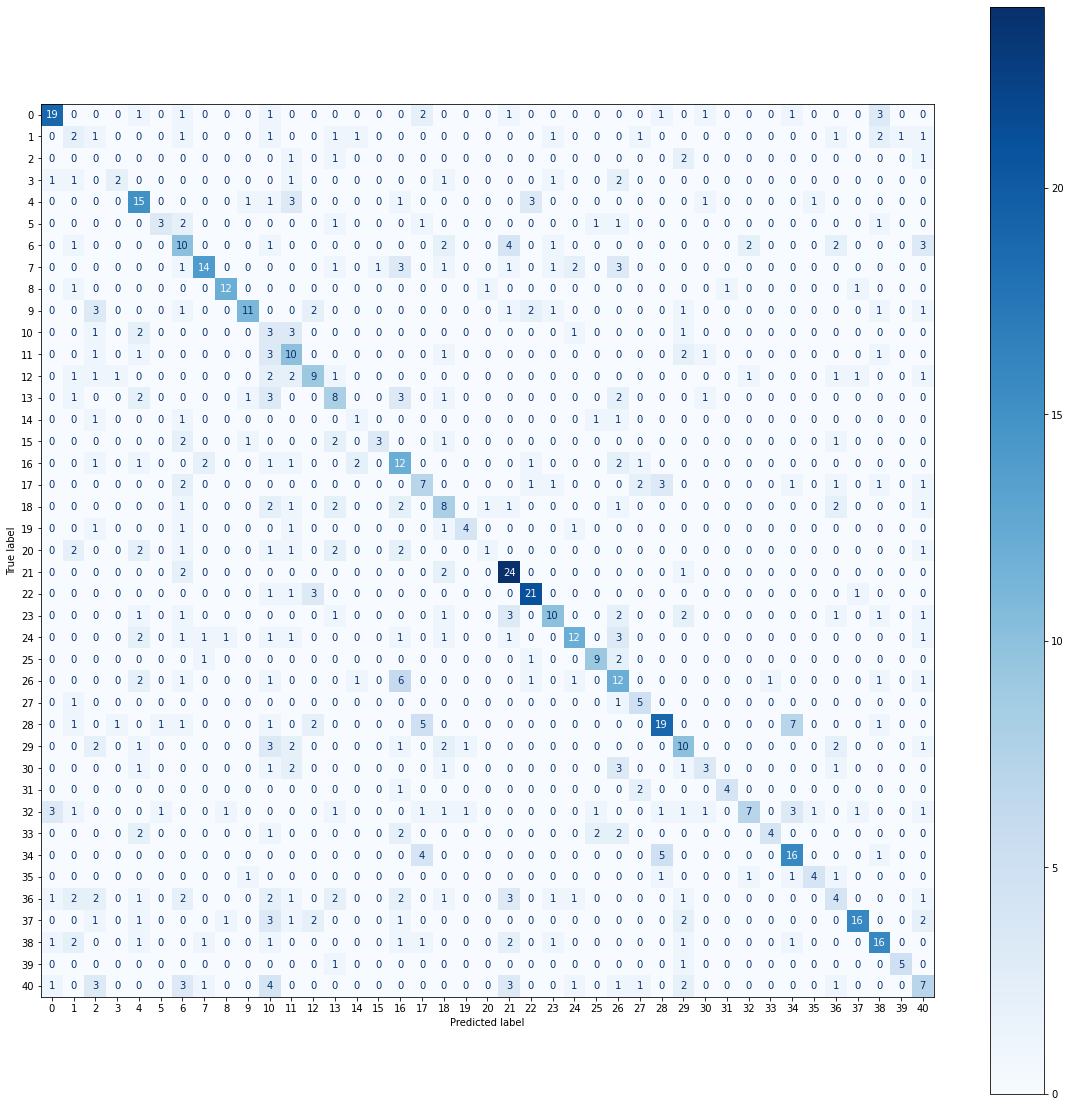

In [ ]:
f = plt.figure(figsize=(20, 20))
ax = plt.axes()
sklearn.metrics.plot_confusion_matrix(cls, test_X_avg_std, test_y, ax=ax, cmap=plt.cm.Blues)#, display_labels=id2label)#, cls.predict())
print(label2id)

In [ ]:
_cls = sklearn.pipeline.Pipeline((('norm', sklearn.preprocessing.Normalizer()), ("cls", sklearn.neighbors.KNeighborsClassifier())))
params = {'cls__n_neighbors': range(1,11), 'cls__metric': ['euclidean', 'minkowski']}
clf_gs = sklearn.model_selection.GridSearchCV(_cls, params, scoring='f1_micro')
clf_gs.fit(train_X_avg_std, train_y)
print(metrics.classification_report(test_y, clf_gs.predict(test_X_avg_std)))

              precision    recall  f1-score   support

           0       0.73      0.61      0.67        31
           1       0.44      0.29      0.35        14
           2       0.12      0.20      0.15         5
           3       1.00      0.44      0.62         9
           4       0.64      0.62      0.63        26
           5       0.75      0.30      0.43        10
           6       0.48      0.38      0.43        26
           7       0.94      0.57      0.71        28
           8       0.92      0.75      0.83        16
           9       0.74      0.58      0.65        24
          10       0.12      0.27      0.17        11
          11       0.44      0.60      0.51        20
          12       0.42      0.38      0.40        21
          13       0.47      0.64      0.54        22
          14       0.09      0.20      0.13         5
          15       0.67      0.40      0.50        10
          16       0.29      0.33      0.31        24
          17       0.56    

In [ ]:
clf_gs.best_params_

{'cls__metric': 'euclidean', 'cls__n_neighbors': 1}

In [ ]:
metrics.accuracy_score(test_y, clf_gs.predict(test_X_avg_std))

0.51125